In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
#from scipy.integrate import simps

In [2]:
Omicron_New_Cases = pd.read_csv('./Data/Omicron_wave_Jan_May.csv',parse_dates=['date'],index_col= ['date'],)
NewCases = Omicron_New_Cases['new_cases'] 

In [3]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau1 = 0.8; tau2 = 0.8; tau =0.8;
psi1 = 0.5; psi = 0.5;
phi1, phi2 = 1/180, 1/180
h1= 0.0045; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/14; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
sevr_im = 2;  # severity impact is higher than the prevalence impact, people react twice higher than the to prevalence info.
#beta1 = (1.72*(eps+mu)*(mu+rho)*(mu+rho+d1))/(eps*((tau1+tau2)*(mu+rho) +(1-tau1)*psi1*(mu+rho+d1)))


theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)

#Dtilde, Btilde = 10, 20
D, B = 50, 50
# Fmax = 0.027; F10 = 0.0029; F20 = (0.1)*F10;
# #Tmax = 0.5; T10 = 0.03; T20 = 0.03
# Tmax = 0.1;  T10 = 0.0023; T20 = T10;  #0.022;
a = 1/3  # fixed to be 3 days 
a1 = 0.5
alpha1, alpha2 = 0.5, 0.5

Fmax = 0.027; F10 = 0.0023; F20 = 0.002;
Tmax = 0.8; T10 = 0.2; T20 = 0.2
d1, d2 = 0.000034, 0.00031

# Fitted parameters
k1=  0.52
beta1=  0.17
beta2=  0.66
xi=  0.99 

In [4]:
S1_dfe = pi/(F10 +mu); S2_dfe = (pi*phi1*F10)/((phi1+mu)*(F10+mu)*(F20+mu)); V1_dfe = (pi*F10)/((phi1+mu)*(F10 +mu));
V2_dfe = (pi*phi1*F10*F20)/(mu*(phi1+mu)*(F10+mu)*(F20+mu));
N_dfe = S1_dfe + S2_dfe + V1_dfe + V2_dfe;

C1 = (beta1*S1_dfe)/N_dfe;  C2 = (1/N_dfe)*(beta2*((1-eta2)*S2_dfe + (1-eta4)*V2_dfe) + (1-eta1)*V1_dfe);

A11 = (1-delta)*T10*(eps/(eps + mu))*(((1-tau)*xi + tau)/(h1 + mu + rho))
A12 = (eps/(eps + mu))*(((xi-1)*tau*T10 + (1-T10*xi))/(mu + rho + d1))


A21 = (1-delta)*T20*(eps/(eps + mu))*(((1-tau)*xi + tau)/(h2 + mu + rho))
A22 = (eps/(eps + mu))*(((xi-1)*tau*T20 + (1-T20*xi))/(mu + rho + d1))

R_e = C1*(A11 + A12) + C2*(A21 + A22)
print('Reproduction number =', R_e)

Reproduction number = 1.2416765498874123


In [5]:
#initial conditions
# Initial conditions
NN = 51815808
V2_0 = 2891 
V1_0 = 431 
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 
I2_0 = 35264 
IT2_0 = 2026
E1_0 = 52694  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 
I1_0 = 5269 
IT1_0 = 2634 
IU1_0 = 0
IU2_0 = 0
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15

MV_0 = k1*((IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(IU1_0 + IU2_0) + d2*H_0)/NN)
S2_0 = 40000000 
S3_0 = 4365186 
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + IU1_0 + IU2_0 + H_0 + R_0)
New_cases_0 = eps*(E1_0 + E2_0 )

S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + IU1_0 + IU2_0 + H_0 + R_0)

In [6]:
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, IU1_0, IU2_0, H_0, R_0, Dth_0, MV_0, MN_0,New_cases_0]

In [7]:
t = np.linspace(0,119,119)
#t = np.linspace(0,500,1000)

In [8]:
def model_eq(x,t):
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, I_U1, I_U2, H, R, Dth, MV, MN, _  = x
    dx = np.zeros(21)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + I_U1 + I_U2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(sevr_im*B*MN)/(1+sevr_im*B*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(sevr_im*B*MN)/(1+sevr_im*B*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*sevr_im*B*MN)/(1+theta*sevr_im*B*MN))
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*sevr_im*B*MN)/(1+theta*sevr_im*B*MN))
    
    L1 = beta1*(I_U1 + I_U2 + (1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I_U1 + I_U2 +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau1)*eps*E1 - a1*A1 
    dx[8] = (1-tau2)*eps*E2 - a1*A2 
    dx[9] = tau1*eps*E1 - I1 
    dx[10] = tau2*eps*E2 - I2 
    dx[11] = a1*xi*T1*A1+ T1*I1 -(rho + h1 + mu)*I_T1
    dx[12] = a1*xi*T2*A2 + T2*I2-(rho + h2 + mu)*I_T2
    dx[13] = a1*(1-xi*T1)*A1 + (1-T1)*I1 -(rho + mu)*I_U1
    dx[14] = a1*(1-xi*T2)*A2+ (1-T2)*I2 - (rho + mu)*I_U2
    dx[15] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[16] = rho*(I_U1 + I_U2 + I_T1 + I_T2) + rhoh*H -(phi2 + mu)*R
    dx[17] = d1*(I_U1+I_U2) + d2*H 
    dx[18] =a*(k1*((I_T1 + I_T2 + H)/NN) - MV)
    dx[19] = a*(k1*((H + d1*(I_U1 + I_U2) + d2*H)/NN)-MN)
    dx[20] = eps*(E1 + E2)
    return dx

In [9]:
for i in [1,2]:
    # Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
    # D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
    
    if i ==1:
        D = 0 ; B = 0; Btilde =0;
        Dtilde = 0
        y = odeint(model_eq,x0,t)
        # Total_cases1 =   x[:,11] + x[:,12] + x[:,13] + x[:,14] + x[:,15] 
        # total_population = x[:,0] + x[:,1] + x[:,2] + x[:,3] +x[:,4] + x[:,5] + x[:,6] + x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13] + x[:,14] + x[:,15] + x[:,16]
        # determined1 = x[:,11] + x[:,12]
        # determined11 = np.divide(determined1,total_population)
        # undetermined1 =  x[:,13] + x[:,14]
        # undetermined11 = np.divide(undetermined1,total_population)
        # total_infected1 = determined1 + undetermined1;
        # Daily_infected1 = eps*(x[:,5] + x[:,6])
        
        #Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:,16],(1+theta*Dtilde*x[:,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:,17],(1+theta*Btilde*x[:,17])) )
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*y[:,18],(1+D*y[:,18])) + (1-alpha1)* np.divide(sevr_im*B*y[:,19],(1+sevr_im*B*y[:,19]))) 
        Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*y[:,18],(1+theta*D*y[:,18])) + (1-alpha2)* np.divide(theta*sevr_im*B*y[:,19],(1+theta*sevr_im*B*y[:,19]))) 

        In1 = np.multiply(Test1_1,(a1*xi*y[:,7]+ y[:,9])) + np.multiply(Test2_1,(a1*xi*y[:,8]+ y[:,10]))
         
        # vacc1 = x[:,3] +x[:,4]
        # Max_Infected1 = max(x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13])
        # Max_Hosp_Dead1 = max (x[:,13] +x[:,15])
        Max_In1 = max(In1)
        # Area1 = simps(In1, t)                              
    
    elif i ==2:
        

        D, B = 50, 50 # reactivity to information in testing (assumed equal)
        
        y = odeint(model_eq,x0,t)
        Total_infected1 = y[:,7] + y[:,8] + y[:,9] + y[:,10]
        
        # for i0 in range(1,len(t)):                
        # Cum_infectious1[i0] = A1_0 + A2_0 + I1_0 + I2_0 + np.trapz(eps*(ret[:i0+1,5] + ret[:i0+1,6] ), t[:i0+1])
        # Total_cases2 =  x[:,7] + x[:,8] + x[:,9] + x[:,10] + x[:,11] + x[:,12] + x[:,13]
        # total_population = x[:,0] + x[:,1] + x[:,2] + x[:,3] +x[:,4] + x[:,5] + x[:,6] + x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13] + x[:,14]
        # determined2 = x[:,11] + x[:,12]
        # Daily_infected2 = eps*(x[:,5] + x[:,6])
        # determined22 = np.divide(determined2,total_population)
        # undetermined2 = x[:,7] + x[:,8] + x[:,9] + x[:,10]
        # undetermined22 = np.divide(undetermined2,total_population)
        # total_infected2 = determined2 + undetermined2;
        Test1_4 = T10 + (Tmax -T10)*(alpha1* np.divide(D*y[:,18],(1+D*y[:,18])) + (1-alpha1)* np.divide(sevr_im*B*y[:,19],(1+sevr_im*B*y[:,19]))) 
        Test2_4 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*y[:,18],(1+theta*D*y[:,18])) + (1-alpha2)* np.divide(theta*sevr_im*B*y[:,19],(1+theta*sevr_im*B*y[:,19])))         
            
        In4 = np.multiply(Test1_4,(xi*y[:,7]+ y[:,9])) + np.multiply(Test2_4,(xi*y[:,8]+ y[:,10]))
        # In_undetected2 = x[:,11] + x[:,12] + x[:,13]
        # vacc2 = x[:,3] +x[:,4]
        # Max_Infected2 = max(x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13])
        # Max_Hosp_Dead2 = max (x[:,13] +x[:,15])
        Max_In4 = max(In4)
        # Max_T1 = max(Test1_4); Max_T2 = max(Test2_4); Max_V1 = max(Vac1_4);Max_V2 = max(Vac2_4);
        # Final_In4 = In4[-1]
        # Area4 = simps(In4, t)


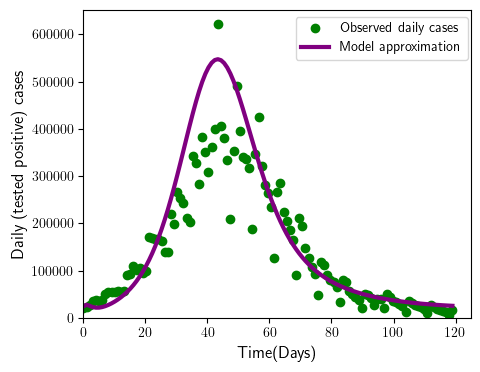

In [10]:
fig, axs = plt.subplots(figsize=(5,4))
B = 2*B
plt.scatter(t,NewCases, label = 'Observed daily cases', color = 'green')
plt.plot(t,In4,label = 'Model approximation',color = 'purple', lw =3)
#plt.plot(t,In1, label = r'Unresponsive case($D = B  =0$)' , color = 'blue', lw = 3)

#plt.text(t[np.argmax(In1)], Max_In1, f'Max: {Max_In1:.0f}', ha='left', va='bottom', color='blue')
#plt.text(t[np.argmax(In4)], Max_In4, f'Max: {Max_In4:.0f}', ha='left', va='bottom', color='purple')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Time(Days)', fontsize=12)
plt.ylabel('Daily (tested positive) cases',fontsize=12)
#plt.title('(a)', loc='left')
plt.legend(bbox_to_anchor = (0.53,1))


# axs[1].plot(t,vacc2, lw=3, color = 'purple', label = 'Baseline case')
# axs[1].plot(t,vacc1, lw=3, color = 'blue', label = 'Unresponsive case')
# axs[1].set_xlim(left=0)
# axs[1].set_ylim(bottom=0)
# axs[1].set_xlabel('Time(Days)', fontsize=16)
# axs[1].set_ylabel('Vaccinated people',fontsize=16)

# axs[1].legend()
plt.savefig('Fig4_Daily_cases_approx.pdf',dpi=600, bbox_inches='tight')
#plt.savefig("Fig6_Daily_cases_approx.eps", format='eps', dpi=400)

plt.show()
#plt.legend(bbox_to_anchor= (0.6,1.25))

In [11]:
t_new = np.linspace(0,1000,1000)

In [12]:
def Ef_Rep_function(T10,T20):
    S1_dfe = pi/(F10 +mu); S2_dfe = (pi*phi1*F10)/((phi1+mu)*(F10+mu)*(F20+mu)); V1_dfe = (pi*F10)/((phi1+mu)*(F10 +mu));
    V2_dfe = (pi*phi1*F10*F20)/(mu*(phi1+mu)*(F10+mu)*(F20+mu));
    N_dfe = S1_dfe + S2_dfe + V1_dfe + V2_dfe;
    
    C1 = (beta1*S1_dfe)/N_dfe;  C2 = (1/N_dfe)*(beta2*((1-eta2)*S2_dfe + (1-eta4)*V2_dfe) + (1-eta1)*V1_dfe);
    
    A11 = (1-delta)*T10*(eps/(eps + mu))*(((1-tau)*xi + tau)/(h1 + mu + rho))
    A12 = (eps/(eps + mu))*(((xi-1)*tau*T10 + (1-T10*xi))/(mu + rho + d1))
    
    
    A21 = (1-delta)*T20*(eps/(eps + mu))*(((1-tau)*xi + tau)/(h2 + mu + rho))
    A22 = (eps/(eps + mu))*(((xi-1)*tau*T20 + (1-T20*xi))/(mu + rho + d1))
    
    R_e = C1*(A11 + A12) + C2*(A21 + A22)
    return R_e

In [13]:
Ef_Rep_function(0.5, 0.5)

0.8860045894511616

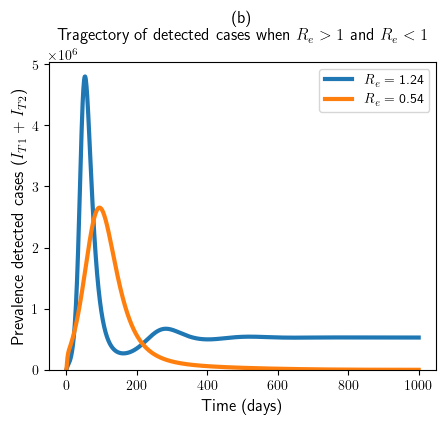

In [14]:
fig, axs = plt.subplots(figsize =(5,4))
for (T10, T20) in zip([0.2, 0.5], [0.2, 0.8]):
    Re_value = Ef_Rep_function(T10, T20)
    y = odeint(model_eq,x0,t_new)
    Total_tested =  y[:,11] + y[:,12]
    axs.plot(t_new,Total_tested, lw = 3, label = f'$R_e =$ {Re_value:.2f}')

axs.set_ylim(bottom = 0)
axs.set_xlabel('Time (days)', fontsize=12)
axs.set_ylabel('Prevalence detected cases ($I_{T1} + I_{T2}$)', fontsize=12)
axs.set_title('(b) \n Tragectory of detected cases when $R_e >1 $ and $R_e < 1$ ', loc='center',fontsize=12,  fontweight='bold')
axs.legend()
plt.savefig('Stability_check.pdf',dpi=600, bbox_inches='tight')
plt.show()